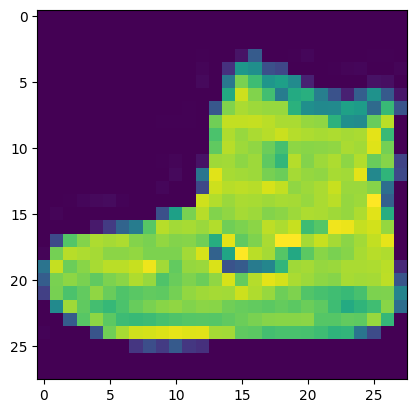

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

plt.imshow(X_train[0])

In [11]:

"""## Reshape and Rescale Images for CycleGAN

Generators will use tanh activation function for the last layer, so we want to reshape X_train to be within -1 to 1 limits.
"""

X_train = X_train/255

X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

X_train.min(), X_train.max()

(np.float64(-1.0), np.float64(1.0))

In [12]:
"""## Prepare Two Domains for CycleGAN Translation
We'll use zeros as Domain A and ones as Domain B
"""

# Domain A: zeros
domain_A = X_train[y_train==0]
# Domain B: ones
domain_B = X_train[y_train==1]

#print(f"Domain A (zeros) shape: {domain_A.shape}")
#print(f"Domain B (ones) shape: {domain_B.shape}")

In [13]:

import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

"""## Build Generators and Discriminators for CycleGAN

CycleGAN needs:
- Generator G: A → B (zeros to ones)
- Generator F: B → A (ones to zeros)
- Discriminator D_A: Identifies real zeros
- Discriminator D_B: Identifies real ones
"""

def build_generator():
    """Build a generator for image-to-image translation"""
    model = Sequential()

    # Encoder
    model.add(Conv2D(32, kernel_size=5, strides=2, padding="same",
                     activation="relu", input_shape=[28, 28, 1]))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                     activation="relu"))
    model.add(BatchNormalization())

    # Decoder
    model.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same",
                              activation="relu"))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                              activation="tanh"))

    return model

def build_discriminator():
    """Build a discriminator to identify real vs fake images"""
    model = Sequential()

    model.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                     activation=LeakyReLU(0.3),
                     input_shape=[28, 28, 1]))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                     activation=LeakyReLU(0.3)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    return model

In [14]:
# Build the models
generator_G = build_generator()  # A -> B (zeros to ones)
generator_F = build_generator()  # B -> A (ones to zeros)

discriminator_A = build_discriminator()  # For domain A (zeros)
discriminator_B = build_discriminator()  # For domain B (ones)

print("Generator G (A->B) summary:")
generator_G.summary()

print("\nDiscriminator A summary:")
discriminator_A.summary()

"""## Compile Discriminators"""

# Compile discriminators
discriminator_A.compile(loss="binary_crossentropy",
                        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                        metrics=['accuracy'])

discriminator_B.compile(loss="binary_crossentropy",
                        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                        metrics=['accuracy'])

Generator G (A->B) summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           801 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,641 (408.75 KB)

 Trainable params: 104,385 (407.75 KB)

 Non-trainable params: 256 (1.00 KB)


Discriminator A summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
"""## Build CycleGAN Combined Model"""

# Make discriminators non-trainable when training generators
discriminator_A.trainable = False
discriminator_B.trainable = False

# Input images from both domains
input_A = tf.keras.Input(shape=[28, 28, 1])
input_B = tf.keras.Input(shape=[28, 28, 1])

# Translate images
fake_B = generator_G(input_A)     # A -> B
fake_A = generator_F(input_B)     # B -> A

# Cycle back to original domain
cycled_A = generator_F(fake_B)    # A -> B -> A
cycled_B = generator_G(fake_A)    # B -> A -> B

# Discriminator outputs
disc_fake_A = discriminator_A(fake_A)
disc_fake_B = discriminator_B(fake_B)

# Identity mapping (optional but helps preserve color/style)
same_A = generator_F(input_A)     # A -> A
same_B = generator_G(input_B)     # B -> B



In [16]:
# Combined model
cycle_gan = Model([input_A, input_B],
                  [disc_fake_B, disc_fake_A,    # Adversarial losses
                   cycled_A, cycled_B,           # Cycle losses
                   same_A, same_B])              # Identity losses

# Compile with multiple losses
cycle_gan.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss=['binary_crossentropy', 'binary_crossentropy',  # Adversarial
          'mae', 'mae',                                   # Cycle consistency
          'mae', 'mae'],                                  # Identity
    loss_weights=[1, 1,                                  # Adversarial weight
                  10, 10,                                 # Cycle weight (higher for consistency)
                  1, 1]                                   # Identity weight
)

In [21]:

"""## Setting up Training Batches"""

batch_size = 64

# Create datasets for both domains
dataset_A = tf.data.Dataset.from_tensor_slices(domain_A).shuffle(buffer_size=1000)
dataset_B = tf.data.Dataset.from_tensor_slices(domain_B).shuffle(buffer_size=1000)

dataset_A = dataset_A.batch(batch_size, drop_remainder=True).prefetch(1)
dataset_B = dataset_B.batch(batch_size, drop_remainder=True).prefetch(1)

epochs = 2  # Reduced for faster training


In [22]:
"""## Training Loop for CycleGAN"""

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Zip the two datasets together
    for i, (batch_A, batch_B) in enumerate(zip(dataset_A, dataset_B)):

        if i % 20 == 0:
            print(f"\tBatch {i}/{min(len(domain_A), len(domain_B))//batch_size}")

        #####################################
        ## TRAIN DISCRIMINATORS ############
        #####################################

        # Generate fake images
        fake_B_imgs = generator_G.predict(batch_A, verbose=0)
        fake_A_imgs = generator_F.predict(batch_B, verbose=0)

        # Train Discriminator A (for zeros)
        # Simply combine real and fake - NO EXTRA CONCATENATION
        X_A = tf.concat([batch_A, fake_A_imgs], axis=0)
        y_A = tf.constant([[1.]] * batch_size + [[0.]] * batch_size)

        discriminator_A.trainable = True
        d_loss_A = discriminator_A.train_on_batch(X_A, y_A)

        # Train Discriminator B (for ones)
        # Simply combine real and fake - NO EXTRA CONCATENATION
        X_B = tf.concat([batch_B, fake_B_imgs], axis=0)
        y_B = tf.constant([[1.]] * batch_size + [[0.]] * batch_size)

        discriminator_B.trainable = True
        d_loss_B = discriminator_B.train_on_batch(X_B, y_B)

        #####################################
        ## TRAIN GENERATORS ################
        #####################################

        # Labels for generator training
        valid = tf.ones((batch_size, 1))

        # Train generators through combined model
        discriminator_A.trainable = False
        discriminator_B.trainable = False

        g_loss = cycle_gan.train_on_batch(
            [batch_A, batch_B],
            [valid, valid,           # Adversarial
             batch_A, batch_B,       # Cycle
             batch_A, batch_B]       # Identity
        )

print("TRAINING COMPLETE")

Epoch 1/2
	Batch 0/93
	Batch 20/93
	Batch 40/93
	Batch 60/93
	Batch 80/93
Epoch 2/2
	Batch 0/93
	Batch 20/93
	Batch 40/93
	Batch 60/93
	Batch 80/93
TRAINING COMPLETE


In [23]:
""## Generate Translations"""

# Test the generators
num_samples = 5

# Select random samples from each domain
idx_A = np.random.randint(0, len(domain_A), num_samples)
idx_B = np.random.randint(0, len(domain_B), num_samples)

samples_A = domain_A[idx_A]
samples_B = domain_B[idx_B]

# Generate translations
fake_B = generator_G.predict(samples_A, verbose=0)
fake_A = generator_F.predict(samples_B, verbose=0)

# Cycle back
cycled_A = generator_F.predict(fake_B, verbose=0)
cycled_B = generator_G.predict(fake_A, verbose=0)

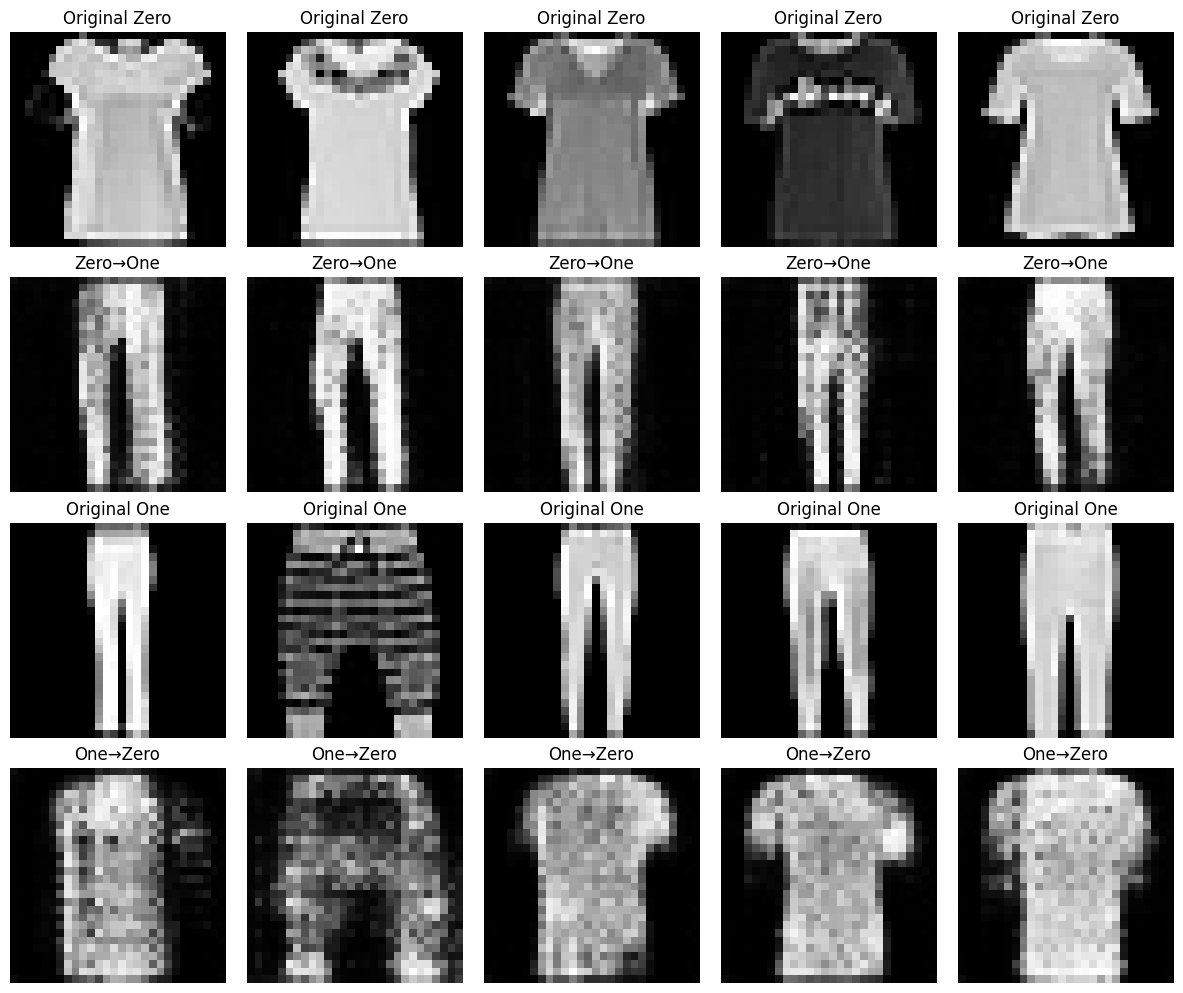

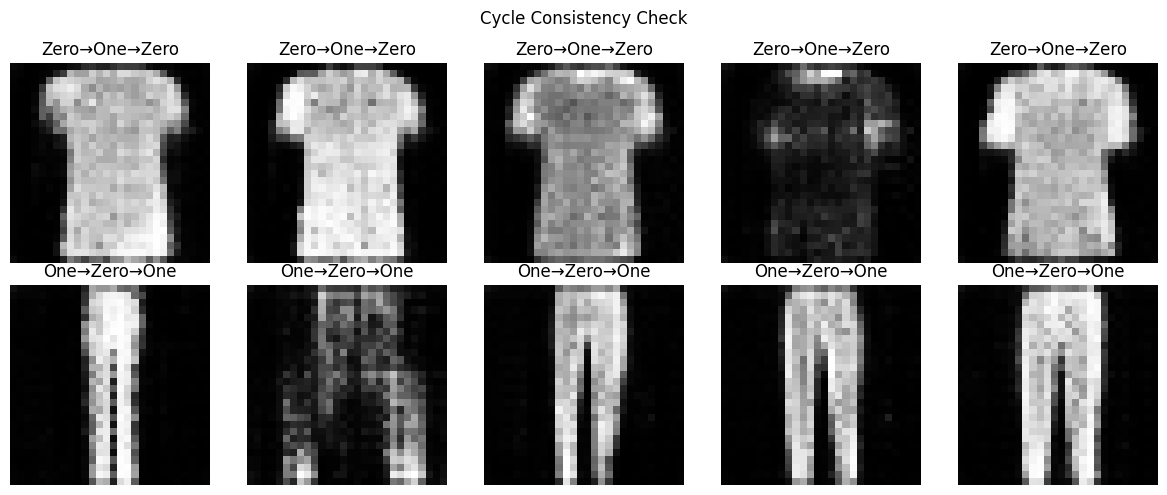

'**CycleGAN successfully learns to translate between digit domains without paired training data!**\n\nThe cycle consistency loss ensures that:\n- DIRECTION 1: Zero -> One -> Reconstructed Zero (matches original)\n- DIRECTION 2: One -> Zero -> Reconstructed One (matches original)\n\nThis forces the generators to learn meaningful, reversible transformations.'

In [24]:
# Visualize results
fig, axes = plt.subplots(4, num_samples, figsize=(12, 10))

for i in range(num_samples):
    # Row 1: Original A (zeros)
    axes[0, i].imshow(samples_A[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Original Zero')
    axes[0, i].axis('off')

    # Row 2: A -> B (zero to one)
    axes[1, i].imshow(fake_B[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Zero→One')
    axes[1, i].axis('off')

    # Row 3: Original B (ones)
    axes[2, i].imshow(samples_B[i].reshape(28, 28), cmap='gray')
    axes[2, i].set_title('Original One')
    axes[2, i].axis('off')

    # Row 4: B -> A (one to zero)
    axes[3, i].imshow(fake_A[i].reshape(28, 28), cmap='gray')
    axes[3, i].set_title('One→Zero')
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

# Show cycle consistency
fig, axes = plt.subplots(2, num_samples, figsize=(12, 5))

for i in range(num_samples):
    # Row 1: A -> B -> A
    axes[0, i].imshow(cycled_A[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Zero→One→Zero')
    axes[0, i].axis('off')

    # Row 2: B -> A -> B
    axes[1, i].imshow(cycled_B[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('One→Zero→One')
    axes[1, i].axis('off')

plt.suptitle('Cycle Consistency Check')
plt.tight_layout()
plt.show()

"""**CycleGAN successfully learns to translate between digit domains without paired training data!**

The cycle consistency loss ensures that:
- DIRECTION 1: Zero -> One -> Reconstructed Zero (matches original)
- DIRECTION 2: One -> Zero -> Reconstructed One (matches original)

This forces the generators to learn meaningful, reversible transformations."""